In [142]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import scvelo as scv
from scvi.nn import Encoder, FCLayers
import anndata
import pandas as pd
import scipy.sparse as sp
import scanpy as sc
from tqdm import tqdm
from torch.distributions import Poisson, NegativeBinomial, kl_divergence, Normal

In [143]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [230]:
adata = anndata.read_h5ad('../../test_simulated_data_continuous_0.h5ad')
print(adata)
adata.layers['raw_unspliced'] = adata.layers['unspliced'].copy()
adata.layers['raw_spliced'] = adata.layers['spliced'].copy()

AnnData object with n_obs × n_vars = 2000 × 1000
    obs: 'cell_state', 'pseudotime'
    var: 'gene_category', 'n_isoforms'
    uns: 'proportions_ground_truth', 'proportions_observed', 'spliced_isoform_counts'
    obsm: 'isoform_counts', 'proportion'
    layers: 'alpha', 'beta', 'gamma', 'spliced', 'unspliced'


# Count Distribution

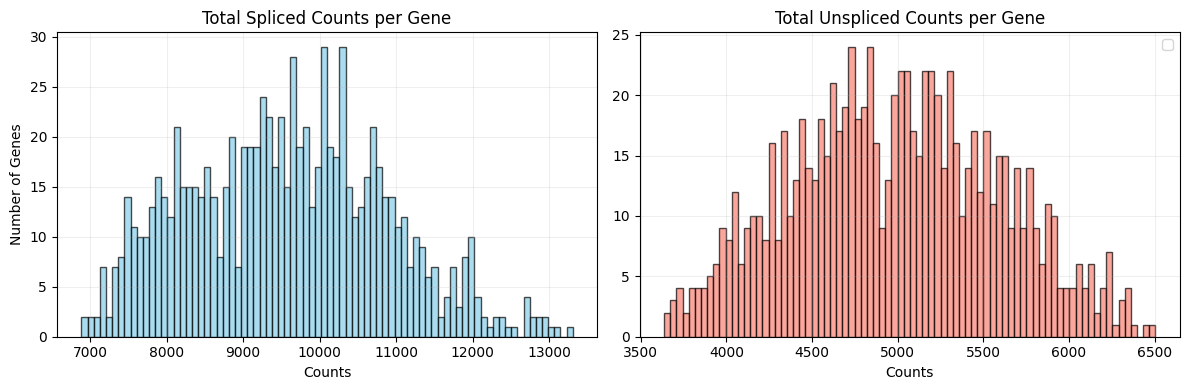

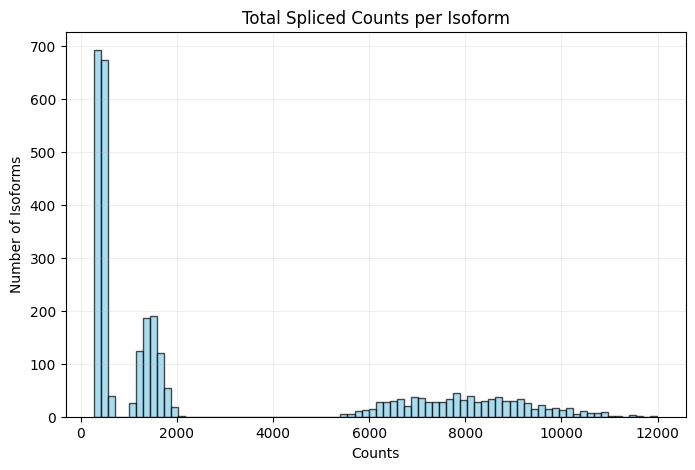

In [176]:
import matplotlib.pyplot as plt
from scvelo.plotting import hist

spliced_counts = adata.layers['spliced'].sum(axis=0)
if hasattr(spliced_counts, "A1"):  # 检查是否为 matrix/sparse 类型
    spliced_counts = spliced_counts.A1

unspliced_counts = adata.layers['unspliced'].sum(axis=0)
if hasattr(unspliced_counts, "A1"):
    unspliced_counts = unspliced_counts.A1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(spliced_counts, bins=80, log=False, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_title('Total Spliced Counts per Gene')
ax1.set_xlabel('Counts')
ax1.set_ylabel('Number of Genes')
ax1.grid(True, which="both", ls="-", alpha=0.2)

ax2.hist(unspliced_counts, bins=80, log=False, color='salmon', edgecolor='black', alpha=0.7)
ax2.set_title('Total Unspliced Counts per Gene')
ax2.set_xlabel('Counts')
ax2.legend()
ax2.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()

isoform_counts = adata.obsm['isoform_counts'].sum(axis=0)
plt.figure(figsize=(8, 5))
plt.hist(isoform_counts, bins=80, log=False, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Total Spliced Counts per Isoform')
plt.xlabel('Counts')
plt.ylabel('Number of Isoforms')
plt.grid(True, which="both", ls="-", alpha=0.2)

# UMAP Visualization

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors


c:\Users\shizh\.conda\envs\IsoVelo_test\lib\site-packages\scvelo\preprocessing\utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
C:\Users\shizh\AppData\Local\Temp\ipykernel_37472\1437440118.py:2: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
c:\Users\shizh\.conda\envs\IsoVelo_test\lib\site-packages\scvelo\preprocessing\moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
c:\Users\shizh\.conda\envs\IsoVelo_test\lib\site-packages\scvelo\preprocessing\neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and w

    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


<Axes: title={'center': 'UMAP Based on Gene Counts'}, xlabel='UMAP1', ylabel='UMAP2'>

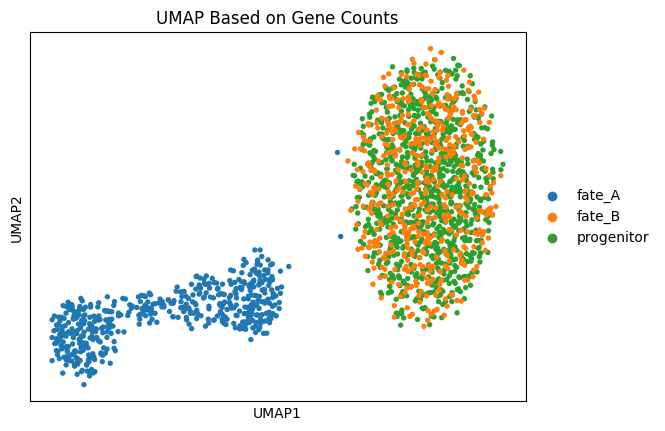

In [231]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20)  
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

sc.tl.pca(adata, svd_solver='arpack', random_state=33)
sc.pp.neighbors(adata, n_pcs=30, random_state=33)
sc.tl.umap(adata, random_state=33)
sc.pl.umap(adata, color='cell_state',
        title='UMAP Based on Gene Counts', show = False)

AnnData object with n_obs × n_vars = 2000 × 3468


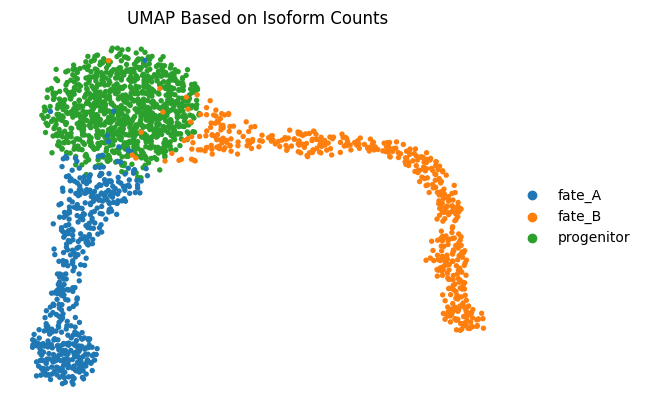

In [232]:
isoforms = list(adata.uns['spliced_isoform_counts'].values())
isoforms = np.concatenate(isoforms, axis=0).T
adata_isoform = anndata.AnnData(isoforms)
print(adata_isoform)
adata_isoform.obs['cell_state'] = adata.obs['cell_state'].values
sc.pp.normalize_total(adata_isoform, target_sum=1e4)
sc.pp.log1p(adata_isoform)
sc.tl.pca(adata_isoform, n_comps=50, random_state=33)
sc.pp.neighbors(adata_isoform, n_pcs=50, random_state=33)
sc.tl.umap(adata_isoform, random_state=33)
sc.pl.umap(
    adata_isoform,
    color='cell_state', 
    title='UMAP Based on Isoform Counts',
    frameon=False
)

# Preprocess by IsoVelo

In [233]:
def preprocess_and_initialize_scvelo(
    adata, 
    isoform_key="isoform_counts", 
    proportion_key = "proportion",
    min_isoform_counts=10, 
    min_cell_counts = 10,
    min_isoform_prop=0.05, 
    n_top_genes=800,
    n_top_splicing = 500,
    min_cells_spanning = 5,
    isoform_delimiter="_",
    normalized = False
):
    """
    Prefilter Isoforms and Genes.
    1. Filter cells, remove low total counts cells.
    2. Filter Isoforms: Remove low expression and low global proportion isoforms.
    3. Filter Genes, keep highly variable genes and isoform proportion variable genes.
    4. Run scVelo dynamical mode.
    5. Return initialization parameters for VAE.
    
    Parameters:
    adata: including layers['unspliced'] and obsm[isoform_key]
    isoform_key: key of isoform count in adata.obsm
    """

    if adata.X is None:
        adata.X = adata.layers['spliced'] + adata.layers['unspliced']

    # 1. Filter cells, remove low total counts cells.
    initial_cell_count = adata.n_obs
    sc.pp.filter_cells(adata, min_counts=min_cell_counts)
    print(f"Filtered cells from {initial_cell_count} to {adata.n_obs} (min_counts={min_cell_counts})")

    # 2. Filter Isoforms: Remove low expression and low global proportion isoforms.
    iso_df = adata.obsm[isoform_key]
    iso_df = iso_df.loc[adata.obs_names]
    isoform_names = iso_df.columns
    try:
        gene_map = pd.Series([x.rsplit(isoform_delimiter, 1)[0] for x in isoform_names], index=isoform_names)
    except Exception as e:
        raise ValueError(f"Error parsing isoform with names '{isoform_delimiter}'. Error: {e}")

    iso_sum = iso_df.sum(axis=0)
    keep_mask_count = iso_sum >= min_isoform_counts

    iso_prop = adata.obsm[proportion_key]
    high_prop_mask = iso_prop >= min_isoform_prop
    cells_passing_count = high_prop_mask.sum(axis=0)
    keep_mask_prop = cells_passing_count >= min_cells_spanning
    keep_isoforms = keep_mask_count & keep_mask_prop

    filtered_iso_df = iso_df.loc[:, keep_isoforms]
    adata.obsm[isoform_key] = filtered_iso_df
    filtered_prop_df = iso_prop.loc[:, keep_isoforms]
    adata.obsm[proportion_key] = filtered_prop_df

    print(f"Filtered isoforms from {iso_df.shape[1]} to {filtered_iso_df.shape[1]} based on isoform expression and global proportion.")

    remaining_isoforms = gene_map[keep_isoforms.values]
    new_counts = pd.Series(remaining_isoforms).value_counts(sort=False)
    adata.var['filtered_n_isoforms'] = 0
    genes_to_update = new_counts.index.intersection(adata.var_names)
    adata.var.loc[genes_to_update, 'filtered_n_isoforms'] = new_counts[genes_to_update]

    # Recalculate proportion dataframe based on remaining isoforms
    current_iso_cols = filtered_iso_df.columns
    current_gene_map = pd.Series([x.rsplit(isoform_delimiter, 1)[0] for x in current_iso_cols], index=current_iso_cols)
    new_gene_counts_df = filtered_iso_df.groupby(current_gene_map.values, axis=1).sum()
    full_spliced_df = pd.DataFrame(
        adata.layers['spliced'], 
        index=adata.obs_names, 
        columns=adata.var_names
    )
    full_spliced_df.update(new_gene_counts_df)
    adata.layers['spliced'] = full_spliced_df.values
    if not normalized:
        adata.X = adata.layers['spliced'] + adata.layers['unspliced']

    gene_ids_per_col = current_gene_map[filtered_iso_df.columns]
    gene_counts_expanded = new_gene_counts_df.loc[:, gene_ids_per_col]
    gene_counts_expanded.columns = filtered_iso_df.columns 
 
    new_props = filtered_iso_df / (gene_counts_expanded)
    adata.obsm[proportion_key] = new_props
      
    # 3. Filter Genes, keep highly variable genes and isoform proportion variable genes.
    adata_hvg = adata.copy()
    if not normalized:
        sc.pp.normalize_total(adata_hvg)
        sc.pp.log1p(adata_hvg)
        sc.pp.highly_variable_genes(adata_hvg, n_top_genes=n_top_genes, flavor='seurat')
        hvg_genes = set(adata_hvg.var_names[adata_hvg.var['highly_variable']])
    else:
        sc.pp.highly_variable_genes(adata_hvg, n_top_genes=n_top_genes, flavor='seurat')
        hvg_genes = set(adata_hvg.var_names[adata_hvg.var['highly_variable']])
    
    print(f"Found {len(hvg_genes)} expression HVGs.")

    iso_variances = new_props.var(axis=0)
    gene_splicing_scores = iso_variances.groupby(current_gene_map.values, sort=False).mean()
    multi_iso_genes = adata.var_names[adata.var['filtered_n_isoforms'] > 1]
    valid_genes = gene_splicing_scores.index.intersection(multi_iso_genes)
    final_scores = gene_splicing_scores.loc[valid_genes]

    if not final_scores.empty:
        top_splicing_genes = final_scores.sort_values(ascending=False).head(n_top_splicing).index.tolist()
        high_splice_genes = set(top_splicing_genes)
    else:
        high_splice_genes = set()
        
    print(f"Identified {len(high_splice_genes)} genes with high splicing variance.")
    
    final_genes_set = (hvg_genes | high_splice_genes)
    final_genes = [gene for gene in adata.var_names if gene in final_genes_set]
    adata = adata[:, final_genes].copy()

    is_isoform_kept = current_gene_map.isin(final_genes_set)
    final_iso_counts = filtered_iso_df.loc[:, is_isoform_kept]
    final_iso_props  = new_props.loc[:, is_isoform_kept]
    adata.obsm[isoform_key] = final_iso_counts
    adata.obsm[proportion_key] = final_iso_props
    
    # 4. Run scVelo dynamical mode.
    print("Preparing scVelo results:")
    if not normalized:
        scv.pp.filter_and_normalize(adata, min_counts=0, min_cells=0, min_shared_counts=20, log=True)
        scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    else:
        scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    
    scv.tl.recover_dynamics(adata, var_names='all', n_jobs=-1)
    scv.tl.latent_time(adata)

    n_total = adata.n_vars
    n_fitted = adata.var['fit_alpha'].notnull().sum()
    print(f"Dynamics recovered for {n_fitted}/{n_total} genes.")

    return adata

In [234]:
adata = preprocess_and_initialize_scvelo(
    adata, 
    isoform_key="isoform_counts", 
    proportion_key = "proportion",
    min_isoform_counts=1000, 
    min_cell_counts = 10,
    min_isoform_prop=0.05, 
    n_top_genes=800,
    n_top_splicing = 500,
    min_cells_spanning = 10,
    isoform_delimiter="_",
    normalized = True
)

Filtered cells from 2000 to 2000 (min_counts=10)
Filtered isoforms from 3468 to 1782 based on isoform expression and global proportion.
Found 800 expression HVGs.
Identified 500 genes with high splicing variance.
Preparing scVelo results:
Normalized count data: spliced.
computing neighbors


C:\Users\shizh\AppData\Local\Temp\ipykernel_37472\2089957631.py:130: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
c:\Users\shizh\.conda\envs\IsoVelo_test\lib\site-packages\scvelo\preprocessing\moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(


    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 32/32 cores)
    finished (0:00:48) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


c:\Users\shizh\.conda\envs\IsoVelo_test\lib\site-packages\scvelo\tools\optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 4 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
Dynamics recovered for 879/879 genes.


AnnData object with n_obs × n_vars = 2000 × 879
    obs: 'cell_state', 'pseudotime', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'gene_category', 'n_isoforms', 'filtered_n_isoforms', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'proportions_ground_truth', 'proportions_observed', 'spliced_isoform_counts', 'log1p', 'pca', 'neighbors', 'umap', 'cell_state_colors', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'isoform_counts', 'proportion', 'X_pca', 'X_umap'
    varm: 'PCs', 'loss'
    layers: 'alpha', 'beta', 'gamma', 'spliced', 'unspliced', 'raw_unspliced', 'ra

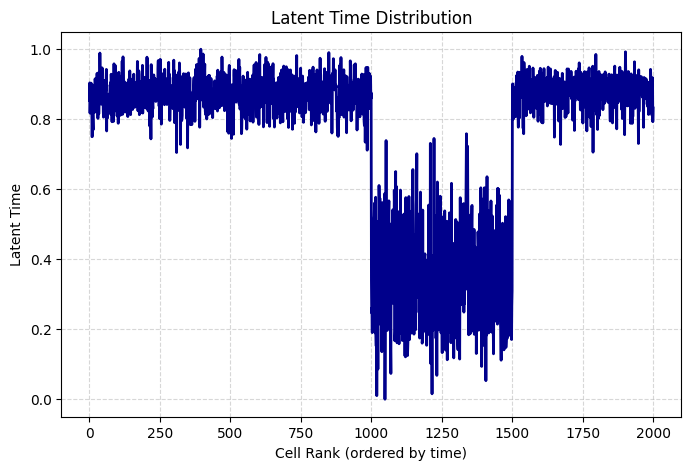

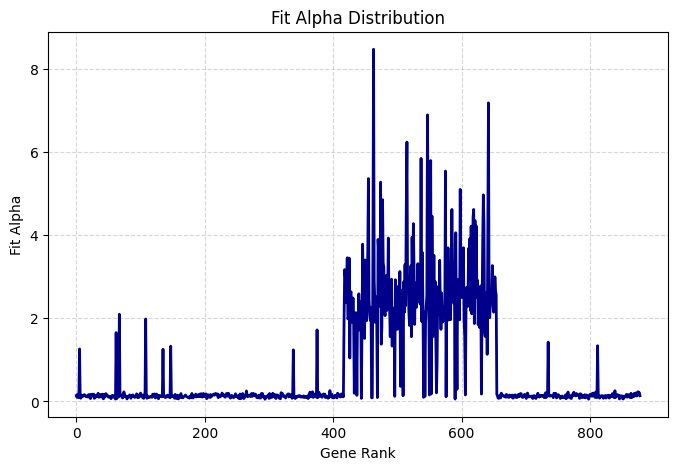

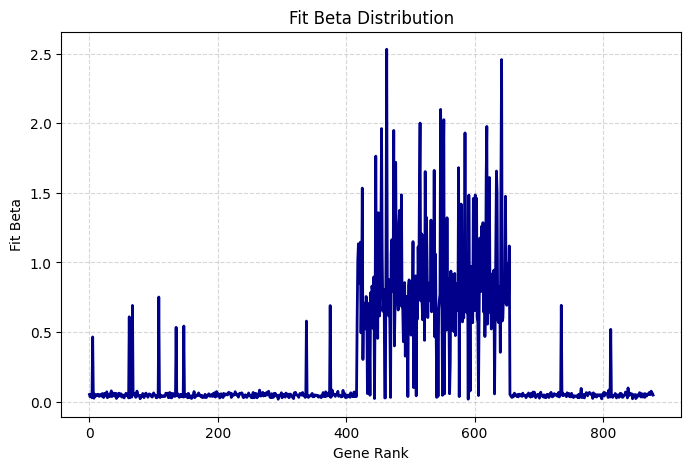

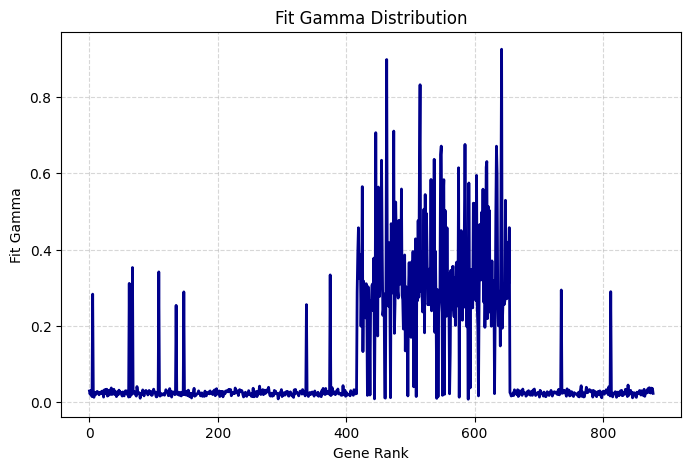

In [206]:
print(adata)
latent_time = adata.obs['latent_time']
plt.figure(figsize=(8, 5))
plt.plot(range(len(latent_time)), latent_time.values, linewidth=2, color='darkblue')

plt.title('Latent Time Distribution')
plt.xlabel('Cell Rank (ordered by time)')
plt.ylabel('Latent Time')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

fit_alpha = adata.var['fit_alpha']
plt.figure(figsize=(8, 5))
plt.plot(range(len(fit_alpha)), fit_alpha.values, linewidth=2, color='darkblue')

plt.title('Fit Alpha Distribution')
plt.xlabel('Gene Rank')
plt.ylabel('Fit Alpha')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

fit_beta = adata.var['fit_beta']
plt.figure(figsize=(8, 5))
plt.plot(range(len(fit_beta)), fit_beta.values, linewidth=2, color='darkblue')

plt.title('Fit Beta Distribution')
plt.xlabel('Gene Rank')
plt.ylabel('Fit Beta')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

fit_gamma = adata.var['fit_gamma']
plt.figure(figsize=(8, 5))
plt.plot(range(len(fit_gamma)), fit_gamma.values, linewidth=2, color='darkblue')

plt.title('Fit Gamma Distribution')
plt.xlabel('Gene Rank')
plt.ylabel('Fit Gamma')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap_isoform', embedded velocity vectors (adata.obsm)


c:\Users\shizh\.conda\envs\IsoVelo_test\lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\shizh\.conda\envs\IsoVelo_test\lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\shizh\.conda\envs\IsoVelo_test\lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\shizh\.conda\envs\IsoVelo_test\lib\site-packages\scvelo\plotting\ut

<Axes: title={'center': 'Gene-Level ScVelo Velocity on Isoform-Based UMAP'}>

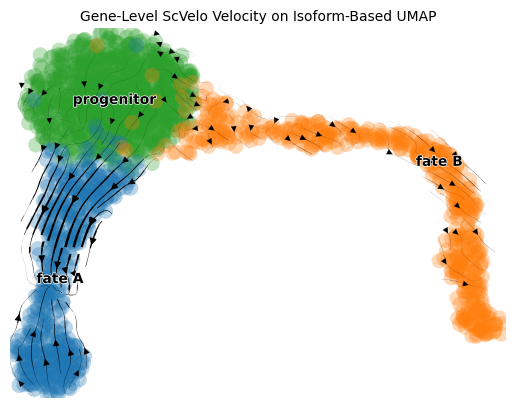

In [235]:
adata.obsm['X_umap_isoform'] = adata_isoform.obsm['X_umap']
scv.pl.velocity_embedding_stream(adata, basis='umap_isoform', color='cell_state',
                                     title='Gene-Level ScVelo Velocity on Isoform-Based UMAP',
                                     show= False)

In [207]:
class IsoDataset(Dataset):
    def __init__(self, adata):
        # Get Unspliced counts (G genes)
        U = adata.layers["raw_unspliced"]
        if sp.issparse(U):
            U = U.toarray()
        
        # Get Isoform counts (I isoforms)
        # Assume that adata.obsm["isoform_counts"] includes spliced isoform count
        I = adata.obsm["isoform_counts"]
        if hasattr(I, "values"): 
            I = I.values
        if sp.issparse(I):        
            I = I.toarray()
            
        # Merge: Cells x (Genes + Isoforms)
        # Note: the input of the Encoder should be G + I
        X = np.hstack([U, I]).astype(np.float32) 
        self.X = torch.from_numpy(X)
        self.n_cells = self.X.shape[0]
        self.n_genes = U.shape[1]
        self.n_isoforms = I.shape[1]

    def __len__(self):
        return self.n_cells

    def __getitem__(self, idx):
        # Get the data and index
        return self.X[idx], idx

In [208]:
class IsoveloEncoder(Encoder):
    """
    Encodes U (unspliced) and Isoform counts into a latent cell embedding.
    Inherits from scvi.nn.Encoder to leverage its VAE structure.
    """
    def __init__(self, 
                 input_dim:int, 
                 hidden_dim=32, 
                 latent_dim = 128, 
                 n_layers=2, 
                 dropout_rate=0.1, 
                 distribution="normal", 
                 use_batch_norm=True, 
                 use_layer_norm=False,
                 var_activation=nn.Softplus(),
                 activation_fn=nn.ReLU,
                 **kwargs):
        super().__init__(n_input=input_dim, 
                         n_output=latent_dim,
                         n_layers=n_layers,
                         n_hidden=hidden_dim,
                         dropout_rate=dropout_rate,
                         distribution=distribution,
                         use_batch_norm=use_batch_norm,
                         use_layer_norm=use_layer_norm,
                         var_activation=var_activation,
                         activation_fn=activation_fn,
                         **kwargs
                         )

    def forward(self, x: torch.Tensor, *cat_list: torch.Tensor):
        """
        Forward pass.
        :param x: Concatenated tensor of [U, Isoforms]
        :return: A dictionary with 'qz_m', 'qz_v', 'z'
        """
        # Encode x to get latent parameters
        qz_m, qz_v, z = super().forward(x, *cat_list)
        
        return {"qz_m": qz_m, "qz_v": qz_v, "z": z}

In [209]:
def build_encoder_from_adata(adata, **enc_kwargs):
    U = adata.layers["raw_unspliced"]
    g = U.shape[1]
    i = adata.obsm["isoform_counts"].shape[1]
    enc = IsoveloEncoder(input_dim=g + i, **enc_kwargs)
    return enc

In [210]:
class IsoveloDecoder(nn.Module):
    def __init__(self,
                 n_cells: int,
                 n_genes: int,
                 n_isoforms: int,
                 latent_dim: int = 128,
                 hidden_dim: int = 256,
                 # Initialization values provided by scVelo
                 init_time: np.ndarray = None,      # shape: (n_cells, )
                 init_alpha: np.ndarray = None,     # shape: (n_genes, )
                 init_beta_iso: np.ndarray = None,  # shape: (n_isoforms, ) <- (beta_gene * proportion)
                 init_gamma: np.ndarray = None,     # shape: (n_isoforms, ) <- (gamma_gene * proportion)
                 iso_to_gene: np.ndarray = None,    # shape: (n_isoforms, ) gene indices for each isoform
                 device = torch.device):
        
        super().__init__()

        def inverse_softplus(x_np):
            x_safe = np.maximum(x_np, 1e-6)
            return np.log(np.exp(x_safe)-1)

        self.n_genes = n_genes
        self.n_isoforms = n_isoforms
        self.device = device
        if iso_to_gene is None:
            raise ValueError("iso_to_gene mapping is required.")
        self.iso_to_gene = torch.from_numpy(iso_to_gene).long().to(self.device)

        # --- A. Cell Time (t) ---
        # independent parameters, not rely on z (cell * 1)
        self.cell_time = nn.Parameter(torch.randn(n_cells, 1)) 
        if init_time is not None:
            # Initialize with the scvelo output
            self.cell_time.data.copy_(torch.from_numpy(init_time).float().unsqueeze(1))

        # --- B. Gamma (γ) ---
        # independent parameters, not rely on z (1 * isoform)
        self.gamma = nn.Parameter(torch.ones(1, n_isoforms))
        if init_gamma is not None:
            # Initialize with the scvelo output
            inv_gamma = inverse_softplus(init_gamma)
            self.gamma.data.copy_(torch.from_numpy(inv_gamma).float().unsqueeze(0))

        # --- C. Alpha Network (α) ---
        # Input: z -> Output: Alpha (Cell * Gene)
        self.alpha_fc1 = nn.Linear(latent_dim, hidden_dim)
        self.alpha_fc2 = nn.Linear(hidden_dim, n_genes) 
        
        # Initialize the bias of the alpha
        if init_alpha is not None:
            # Initial weights should be small, the initial values should be determined mainly by the scvelo bias
            nn.init.xavier_normal_(self.alpha_fc2.weight, gain=0.01)
            # Set the bias to scvelo output (usually need to get log or inverse softplus, depending on the activation function)
            # Assume that using Softplus activation. For simplicity, set to scvelo output, training will approximate these values
            inv_alpha = inverse_softplus(init_alpha)
            self.alpha_fc2.bias.data.copy_(torch.from_numpy(inv_alpha).float())

        # --- D. Beta Network (β) ---
        # Input: z -> Output: Beta (Cell * Isoform)
        self.beta_fc1 = nn.Linear(latent_dim, hidden_dim)
        self.beta_fc2 = nn.Linear(hidden_dim, n_isoforms) 
        
        # Initialize the bias of the beta
        if init_beta_iso is not None:
            nn.init.xavier_normal_(self.beta_fc2.weight, gain=0.01)
            # Similar with alpha, here it should be isoform level beta
            inv_beta = inverse_softplus(init_beta_iso)
            self.beta_fc2.bias.data.copy_(torch.from_numpy(inv_beta).float())

    def forward(self, z: torch.Tensor, cell_indices = None):
        """
        z: [Batch, Latent_dim]
        cell_indices: [Batch]
        """
        # 1. Get cell time
        if cell_indices is not None:
            t = self.cell_time[cell_indices] # [Batch, 1]
        else:
            t = self.cell_time

        # 2. Get alpha (non-negative)
        h_alpha = F.relu(self.alpha_fc1(z))
        alpha = F.softplus(self.alpha_fc2(h_alpha)) # [Batch, n_genes]

        # 3. Get beta (non-negative)
        h_beta = F.relu(self.beta_fc1(z))
        beta = F.softplus(self.beta_fc2(h_beta))   # [Batch, n_isoforms]

        # 4. Get gamma (non-negative)
        gamma = F.softplus(self.gamma)             # [1, n_isoforms]

        # Compute integrated u_hat and s_hat using analytical ODE solution
        b_size = z.shape[0]

        # Compute beta_total [b_size, n_genes]
        beta_total = torch.zeros(b_size, self.n_genes, device=self.device)
        beta_total.scatter_add_(1, self.iso_to_gene.unsqueeze(0).expand(b_size, -1), beta)
        beta_total = torch.clamp(beta_total, min=1e-6)

        # a_g [b_size, n_genes]
        a_g = alpha / beta_total

        # u_hat [b_size, n_genes]
        exp_bt = torch.exp(-beta_total * t)
        u_hat = a_g * (1 - exp_bt)

        # s_hat [b_size, n_isoforms]
        g_idx = self.iso_to_gene
        a_expand = torch.index_select(a_g, 1, g_idx)  # [b_size, n_isoforms]
        b_expand = torch.index_select(beta_total, 1, g_idx)  # [b_size, n_isoforms]
        gamma_expand = gamma.expand(b_size, -1)  # [b_size, n_isoforms]
        t_expand = t.expand(-1, self.n_isoforms)  # [b_size, n_isoforms]


        denom = gamma_expand - b_expand
        mask = torch.abs(denom) < 1e-6
        s_hat = torch.zeros_like(beta)
        non_mask = ~mask
        s_hat[non_mask] = beta[non_mask] * a_expand[non_mask] * (
            1.0 / gamma_expand[non_mask]
            - torch.exp(-gamma_expand[non_mask] * t_expand[non_mask]) / gamma_expand[non_mask]
            - torch.exp(-b_expand[non_mask] * t_expand[non_mask]) / denom[non_mask]
            + torch.exp(-gamma_expand[non_mask] * t_expand[non_mask]) / denom[non_mask]
        )
        s_hat[mask] = beta[mask] * a_expand[mask] * (
            (1.0 - torch.exp(-b_expand[mask] * t_expand[mask])) / b_expand[mask]
            - t_expand[mask] * torch.exp(-b_expand[mask] * t_expand[mask])
        )

        #### Test
        u_hat = torch.clamp(u_hat, min=0.0)
        s_hat = torch.clamp(s_hat, min=0.0)
        
        return {"cell_time": t, "gene_alpha": alpha, "isoform_beta": beta, "isoform_gamma": gamma,
                "u_hat": u_hat, "s_hat": s_hat}


In [211]:
print(adata)
def build_decoder_from_adata(adata, latent_dim=128, hidden_dim=256, device=torch.device):
    n_cells = adata.n_obs
    n_genes = adata.n_vars
    n_isoforms = adata.obsm['isoform_counts'].shape[1]
    # Get init_time
    init_time = adata.obs['latent_time'].values if 'latent_time' in adata.obs else None
    # Get init_alpha
    init_alpha = adata.var['fit_alpha'].values if 'fit_alpha' in adata.var else None
    # Get gene_map for isoforms
    isoform_names = adata.obsm['isoform_counts'].columns if hasattr(adata.obsm['isoform_counts'], 'columns') else [str(i) for i in range(n_isoforms)]
    isoform_delimiter = "_"
    gene_names = [x.rsplit(isoform_delimiter, 1)[0] for x in isoform_names]
    # gene_idx_for_iso
    gene_to_idx = {g: i for i, g in enumerate(adata.var_names)}
    iso_to_gene_idx = np.array([gene_to_idx[g] for g in gene_names])

    adata.uns['iso_to_gene'] = iso_to_gene_idx

    
    # init_beta_iso, init_gamma
    init_beta_iso = None
    init_gamma_iso = None
    if 'fit_beta' in adata.var and 'proportion' in adata.obsm:
        mean_prop = np.nanmean(adata.obsm['proportion'], axis=0)
        beta_gene = adata.var['fit_beta'].reindex(gene_names).values
        gamma_gene = adata.var['fit_gamma'].reindex(gene_names).values
        init_beta_iso = beta_gene * mean_prop
        init_gamma_iso = gamma_gene * mean_prop
    dec = IsoveloDecoder(n_cells, n_genes, n_isoforms, latent_dim, hidden_dim,
                         init_time=init_time, init_alpha=init_alpha, init_beta_iso=init_beta_iso, init_gamma=init_gamma_iso,
                         iso_to_gene=iso_to_gene_idx, device=device)
    return dec

AnnData object with n_obs × n_vars = 2000 × 879
    obs: 'cell_state', 'pseudotime', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'gene_category', 'n_isoforms', 'filtered_n_isoforms', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'proportions_ground_truth', 'proportions_observed', 'spliced_isoform_counts', 'log1p', 'pca', 'neighbors', 'umap', 'cell_state_colors', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'isoform_counts', 'proportion', 'X_pca', 'X_umap'
    varm: 'PCs', 'loss'
    layers: 'alpha', 'beta', 'gamma', 'spliced', 'unspliced', 'raw_unspliced', 'ra

In [212]:
class IsoveloVAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, mu, var):
        std = torch.sqrt(var + 1e-6)  # Add epsilon for stability
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, cell_indices):
        enc_out = self.encoder(x)
        z_mu = enc_out['qz_m']
        z_var = enc_out['qz_v']
        z = self.reparameterize(z_mu, z_var)
        dec_out = self.decoder(z, cell_indices)
        return enc_out, dec_out, z_mu, z_var, z

In [213]:
def compute_loss(model, x, cell_indices, n_genes, kl_weight=1.0):
    enc_out, dec_out, z_mu, z_var, z = model(x, cell_indices)
    u_hat = dec_out['u_hat']
    s_hat = dec_out['s_hat']
    
    # Observed data from x: first n_genes are unspliced, rest are isoform spliced
    u_obs = x[:, :n_genes]
    s_obs = x[:, n_genes:]
    
    # Reconstruction loss: Use Normal for continuous data
    # Variance approximation: sqrt(mean + epsilon) for stability and Poisson-like behavior
    # recon_loss_u = -Normal(u_hat, torch.sqrt(u_hat + 1e-6)).log_prob(u_obs).sum(dim=1).mean()
    # recon_loss_s = -Normal(s_hat, torch.sqrt(s_hat + 1e-6)).log_prob(s_obs).sum(dim=1).mean()

    ##### Try normal
    recon_loss_u = -Normal(u_hat, torch.sqrt(u_hat + 1e-6)).log_prob(u_obs).sum(dim=1).mean()
    recon_loss_s = -Normal(s_hat, torch.sqrt(s_hat + 1e-6)).log_prob(s_obs).sum(dim=1).mean()
    
    # KL divergence for latent z
    kl_loss = kl_divergence(Normal(z_mu, torch.sqrt(z_var)), Normal(0, 1)).sum(dim=1).mean()
    
    total_loss = recon_loss_u + recon_loss_s + kl_weight * kl_loss
    return total_loss, recon_loss_u, recon_loss_s, kl_loss

In [236]:
def train_isovelo(adata, batch_size=128, epochs=100, lr=1e-3, kl_weight=1.0, device=torch.device('cpu')):
    dataset = IsoDataset(adata)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    n_genes = dataset.n_genes
    encoder = build_encoder_from_adata(adata, latent_dim=128, hidden_dim=32)
    decoder = build_decoder_from_adata(adata, latent_dim=128, hidden_dim=256, device=device)
    
    model = IsoveloVAE(encoder, decoder).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_recon_u = 0
        epoch_recon_s = 0
        epoch_kl = 0
        for batch in dataloader:
            x, idx = batch
            x = x.to(device)
            idx = idx.to(device)
            
            optimizer.zero_grad()
            loss, recon_u, recon_s, kl = compute_loss(model, x, idx, n_genes, kl_weight)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_recon_u += recon_u.item()
            epoch_recon_s += recon_s.item()
            epoch_kl += kl.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(dataloader):.4f}, recon_u: {epoch_recon_u / len(dataloader):.4f}, recon_s: {epoch_recon_s / len(dataloader):.4f}, kl: {epoch_kl / len(dataloader):.4f}")
    
    # After training, can extract latent z, times, etc.
    model.eval()
    with torch.no_grad():
        full_dataloader = DataLoader(dataset, batch_size=adata.n_obs, shuffle=False)
        x_full, idx_full = next(iter(full_dataloader))
        x_full = x_full.to(device)
        idx_full = idx_full.to(device)
        enc_out, dec_out, z_mu, z_var, z = model(x_full, idx_full)
        adata.obsm['X_isovelo'] = z.cpu().numpy()  # Latent representation
        adata.obs['isovelo_time'] = dec_out['cell_time'].squeeze().cpu().numpy()
        
        # Extract predicted parameters
        alpha = dec_out['gene_alpha'].cpu().numpy()  # cell x gene
        beta = dec_out['isoform_beta'].cpu().numpy()  # cell x isoform
        gamma = dec_out['isoform_gamma'].cpu().numpy()[0]  # isoform (global)
        adata.layers['isovelo_alpha'] = alpha
        adata.obsm['isovelo_beta'] = beta
        adata.uns['isovelo_gamma'] = gamma  # 1D array for isoforms
        
        # Compute RNA velocities using predicted params and observed u/s        
        iso_to_gene = adata.uns['iso_to_gene']
        n_cells = adata.n_obs
        n_genes = adata.n_vars
        n_isoforms = beta.shape[1]
        
        # Compute beta_total (cell x gene)
        beta_total = np.zeros((n_cells, n_genes))
        for i in range(n_isoforms):
            g_idx = iso_to_gene[i]
            beta_total[:, g_idx] += beta[:, i]
        beta_total = np.maximum(beta_total, 1e-6)
        
        # Get observed u and s
        u_obs = adata.layers['unspliced']
        if sp.issparse(u_obs):
            u_obs = u_obs.toarray()
        s_obs = adata.obsm['isoform_counts']
        if hasattr(s_obs, 'values'):
            s_obs = s_obs.values
        if sp.issparse(s_obs):
            s_obs = s_obs.toarray()
        
        # Unspliced velocity (cell x gene)
        velocity_u = alpha - beta_total * u_obs
        adata.layers['velocity_u'] = velocity_u
        
        # Spliced velocity (cell x isoform)
        velocity_s = np.zeros_like(beta)
        for i in range(n_isoforms):
            g_idx = iso_to_gene[i]
            velocity_s[:, i] = beta[:, i] * u_obs[:, g_idx] - gamma[i] * s_obs[:, i]
        adata.obsm['velocity_s'] = velocity_s
        
        # Aggregate spliced velocity to gene-level for scVelo compatibility
        velocity_s_gene = np.zeros((n_cells, n_genes))
        for i in range(n_isoforms):
            g_idx = iso_to_gene[i]
            velocity_s_gene[:, g_idx] += velocity_s[:, i]
        adata.layers['velocity'] = velocity_s_gene  # Set for velocity_graph
    
    # Prepare embeddings and velocity graph for visualization
    #sc.pp.neighbors(adata, use_rep='X_isovelo', n_neighbors=30)
    #sc.tl.umap(adata)
    #scv.tl.velocity_graph(adata)
    
    return model, adata

In [237]:
model, trained_adata = train_isovelo(adata, batch_size=64, epochs=200, lr=0.001, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Epoch 1/200, Loss: 21532337.0991, recon_u: 2409153.1149, recon_s: 19123154.1237, kl: 28.1162
Epoch 2/200, Loss: 36952.5335, recon_u: 3221.3744, recon_s: 33696.2807, kl: 34.8780
Epoch 3/200, Loss: 18427.1336, recon_u: 2938.7681, recon_s: 15450.3934, kl: 37.9721
Epoch 4/200, Loss: 16027.3155, recon_u: 2887.4059, recon_s: 13099.7511, kl: 40.1587
Epoch 5/200, Loss: 13010.9934, recon_u: 2797.8304, recon_s: 10171.2927, kl: 41.8702
Epoch 6/200, Loss: 11961.8072, recon_u: 2729.9884, recon_s: 9189.1010, kl: 42.7177
Epoch 7/200, Loss: 10786.7906, recon_u: 2677.8846, recon_s: 8065.4270, kl: 43.4791
Epoch 8/200, Loss: 10209.2195, recon_u: 2615.2770, recon_s: 7548.9970, kl: 44.9455
Epoch 9/200, Loss: 10080.6006, recon_u: 2558.1370, recon_s: 7476.6404, kl: 45.8232
Epoch 10/200, Loss: 9050.1878, recon_u: 2504.4745, recon_s: 6499.0491, kl: 46.6642
Epoch 11/200, Loss: 8761.0948, recon_u: 2449.8146, recon_s: 6263.9808, kl: 47.2993
Epoch 12/200, Loss: 8485.2344, recon_u: 2388.0275, recon_s: 6048.7674, kl

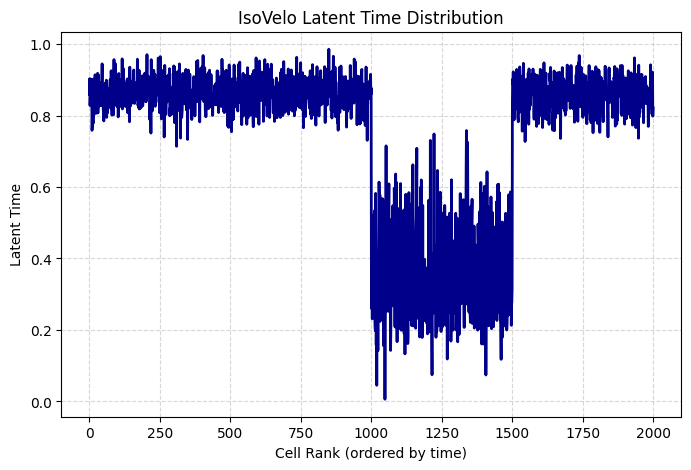

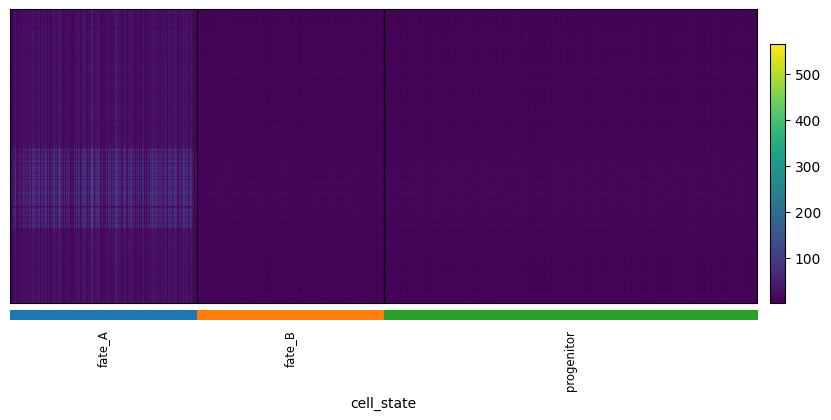

In [ ]:
isovelo_time = adata.obs['isovelo_time']
plt.figure(figsize=(8, 5))
plt.plot(range(len(isovelo_time)), isovelo_time.values, linewidth=2, color='darkblue')

plt.title('IsoVelo Latent Time Distribution')
plt.xlabel('Cell Rank (ordered by time)')
plt.ylabel('Latent Time')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

sc.pl.heatmap(adata, var_names = adata.var_names, groupby='cell_state', 
              layer='isovelo_alpha', cmap='viridis', swap_axes=True)


<Axes: >

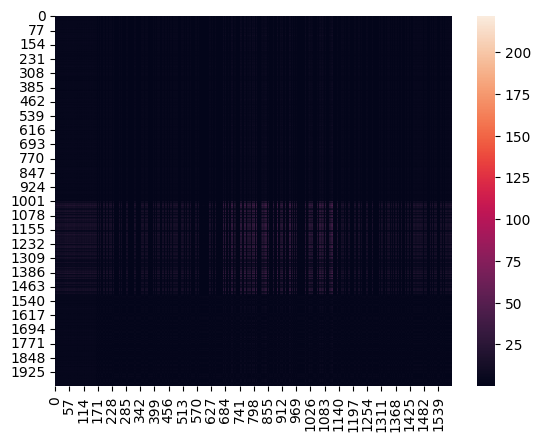

In [253]:
from seaborn import heatmap


heatmap(adata.obsm['isovelo_beta'])

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


c:\Users\shizh\.conda\envs\IsoVelo_test\lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\shizh\.conda\envs\IsoVelo_test\lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\shizh\.conda\envs\IsoVelo_test\lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\shizh\.conda\envs\IsoVelo_test\lib\site-packages\scvelo\plotting\ut

<Axes: title={'center': 'Gene-Level ScVelo Velocity on Gene-Based UMAP'}>

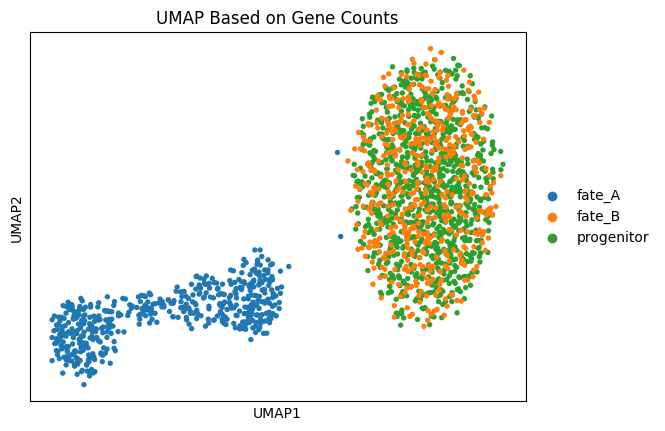

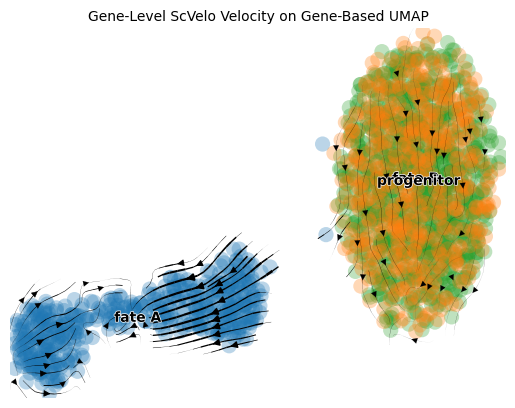

In [250]:
sc.pl.umap(adata, color='cell_state',
        title='UMAP Based on Gene Counts', show = False)
scv.pl.velocity_embedding_stream(adata, basis='X_umap', color='cell_state',
                                     title='Gene-Level ScVelo Velocity on Gene-Based UMAP',
                                     show= False)

Test

In [22]:
adata.obsm['proportion']

,gene0_isoform0,gene0_isoform1,gene0_isoform2,gene0_isoform3,gene0_isoform4,gene1_isoform0,gene1_isoform1,gene1_isoform2,gene2_isoform0,gene2_isoform1,...,gene997_isoform0,gene997_isoform1,gene998_isoform0,gene998_isoform1,gene998_isoform2,gene999_isoform0,gene999_isoform1,gene999_isoform2,gene999_isoform3,gene999_isoform4
cell0,0.002771,0.000183,0.055434,0.783882,0.157730,0.092371,0.019413,0.888215,0.012982,0.935811,...,0.025368,0.974632,0.039979,0.949587,0.010434,0.013327,0.008082,0.897071,0.038516,0.043005
cell1,0.069436,0.027645,0.038120,0.711690,0.153109,0.011709,0.150345,0.837946,0.031030,0.945185,...,0.041177,0.958823,0.024048,0.907134,0.068818,0.044004,0.076466,0.793215,0.060215,0.026101
cell2,0.036947,0.099650,0.039248,0.821082,0.003073,0.019592,0.000135,0.980273,0.006178,0.967000,...,0.168463,0.831537,0.061806,0.929543,0.008651,0.042498,0.004834,0.907459,0.024848,0.020361
cell3,0.011987,0.062847,0.021297,0.891863,0.012006,0.124549,0.013793,0.861658,0.005194,0.921849,...,0.000429,0.999571,0.036014,0.906556,0.057429,0.080205,0.022818,0.845171,0.019799,0.032007
cell4,0.027065,0.005179,0.049520,0.912792,0.005445,0.011394,0.007370,0.981235,0.129561,0.869357,...,0.012906,0.987094,0.020643,0.940613,0.038743,0.040638,0.100550,0.802722,0.038924,0.017165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell1995,0.027365,0.004360,0.055163,0.787518,0.125594,0.138441,0.098001,0.763558,0.083523,0.898684,...,0.846623,0.153377,0.005166,0.227879,0.766956,0.033292,0.100374,0.150069,0.050855,0.665410
cell1996,0.051143,0.027791,0.000495,0.870665,0.049907,0.010933,0.008555,0.980512,0.088887,0.907819,...,0.038461,0.961539,0.071915,0.886500,0.041585,0.040483,0.017764,0.804311,0.082368,0.055074
cell1997,0.035424,0.027809,0.029545,0.888807,0.018415,0.131065,0.004510,0.864425,0.098264,0.833042,...,0.038984,0.961016,0.035882,0.937306,0.026813,0.008932,0.003378,0.814616,0.154557,0.018516
cell1998,0.038887,0.011101,0.057584,0.861432,0.030996,0.009846,0.026444,0.963710,0.076589,0.886500,...,0.138428,0.861572,0.005505,0.802444,0.192051,0.015179,0.015678,0.766043,0.048797,0.154303


In [11]:
gene_splicing_scores[750:]

gene750    0.0
gene751    0.0
gene752    0.0
gene753    0.0
gene754    0.0
          ... 
gene995    0.0
gene996    0.0
gene997    0.0
gene998    0.0
gene999    0.0
Length: 250, dtype: float64